# Machine learning pipeline for modelling fraction of precipitation in different intensity bands

This notebook is designed to be run in AzureML 

### Import relevant libraries

In [3]:
import pathlib
import os
import datetime
import json

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# %load_ext tensorboard

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Reshape, Input, Dropout, PReLU
from tensorflow.keras.models import Sequential, Model

In [7]:
import prd_pipeline

In [8]:
pathlib.Path.cwd().parent

PosixPath('/mnt/batch/tasks/shared/LS_root/mounts/clusters/prd-ml-pipeline/code/Users/stephen.haddad/prd_fractional')

Set up MLops for experiment tracking in AzureML

In [9]:
import mlflow
mlflow.tensorflow.autolog()

In [10]:
import azureml.core
from azureml.core import Workspace, Datastore, Dataset
from azureml.core import Experiment

prd_ws = Workspace.from_config()

In [11]:
mlflow.set_tracking_uri(prd_ws.get_mlflow_tracking_uri())

### Load and preprocess data

In [14]:
prd_prefix = 'prd'
merged_prefix = prd_prefix + '_merged'
csv_file_suffix = 'csv'

In [20]:
target_parameter = [
    'radar_fraction_in_band_instant_0.0',
    'radar_fraction_in_band_instant_0.25',
    'radar_fraction_in_band_instant_2.5',
    'radar_fraction_in_band_instant_7.0',
    'radar_fraction_in_band_instant_10.0'
]
profile_features = ['air_temperature', 'relative_humidity','u_wind', 'v_wind']# 'wind_speed', 'wind_from_direction'] #'air_pressure','cloud_volume_fraction',
single_lvl_features = [] #['surface_altitude']#,'air_pressure_at_sea_level','cloud_area_fraction']#'thickness_of_rainfall_amount']#] 

In [24]:
feature_dict = {
    'profile': profile_features,
    'single_level': single_lvl_features,
    'target': target_parameter,
} 

In [2]:
load_all = False

In [15]:
if load_all:
    prd_azml_dataset_name = 'prd_merged_all_events_files'
else:
    prd_azml_dataset_name = 'prd_merged_202110_nswws_amber_oct_files'


In [17]:
prd_azml_dataset = azureml.core.Dataset.get_by_name(prd_ws, name=prd_azml_dataset_name)

In [18]:
with prd_azml_dataset.mount() as prd_mount:
    print('loading all data')
    prd_path_list = [p1 for p1 in pathlib.Path(prd_mount.mount_point).rglob('*csv') ]
    merged_df = pd.concat([pd.read_csv(p1) for p1 in prd_path_list])

Volume mount is not enabled. 
Falling back to dataflow mount.
loading all data


In [19]:
merged_df

,realization,latitude,longitude,forecast_period,forecast_reference_time,time,cloud_area_fraction,surface_altitude,air_pressure_at_sea_level,rainfall_rate,...,radar_fraction_in_band_aggregate_3hr_0.0,radar_fraction_in_band_aggregate_3hr_0.25,radar_fraction_in_band_aggregate_3hr_2.5,radar_fraction_in_band_aggregate_3hr_7.0,radar_fraction_in_band_aggregate_3hr_10.0,radar_fraction_in_band_instant_0.0,radar_fraction_in_band_instant_0.25,radar_fraction_in_band_instant_2.5,radar_fraction_in_band_instant_7.0,radar_fraction_in_band_instant_10.0
0,0,49.40625,-5.484375,0 days 06:00:00,2021-10-19 12:00:00,2021-10-19 18:00:00,1.000000,0.0,100931.0,1.991540,...,0.0,0.0,0.0,0.781176,0.218824,0.0,0.082353,0.903529,0.021176,0.0
1,1,49.40625,-5.484375,0 days 06:00:00,2021-10-19 12:00:00,2021-10-19 18:00:00,1.000000,0.0,100937.0,2.967194,...,0.0,0.0,0.0,0.781176,0.218824,0.0,0.082353,0.903529,0.021176,0.0
2,2,49.40625,-5.484375,0 days 06:00:00,2021-10-19 12:00:00,2021-10-19 18:00:00,1.000000,0.0,100959.0,4.050136,...,0.0,0.0,0.0,0.781176,0.218824,0.0,0.082353,0.903529,0.021176,0.0
3,3,49.40625,-5.484375,0 days 06:00:00,2021-10-19 12:00:00,2021-10-19 18:00:00,1.000000,0.0,101007.0,0.865012,...,0.0,0.0,0.0,0.781176,0.218824,0.0,0.082353,0.903529,0.021176,0.0
4,4,49.40625,-5.484375,0 days 06:00:00,2021-10-19 12:00:00,2021-10-19 18:00:00,1.000000,0.0,100912.0,2.182648,...,0.0,0.0,0.0,0.781176,0.218824,0.0,0.082353,0.903529,0.021176,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186979,13,58.78125,1.546875,0 days 06:00:00,2021-10-21,2021-10-21 06:00:00,1.000000,0.0,98909.0,0.000000,...,1.0,0.0,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.0
186980,14,58.78125,1.546875,0 days 06:00:00,2021-10-21,2021-10-21 06:00:00,1.000000,0.0,99012.0,0.000000,...,1.0,0.0,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.0
186981,15,58.78125,1.546875,0 days 06:00:00,2021-10-21,2021-10-21 06:00:00,0.484375,0.0,98904.0,0.000000,...,1.0,0.0,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.0
186982,16,58.78125,1.546875,0 days 06:00:00,2021-10-21,2021-10-21 06:00:00,0.796875,0.0,99010.0,0.000000,...,1.0,0.0,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.0


## Calculate u and v wind fields and add column to dataset <i>- to be moved into data prep </i>

Adding columns with u and v wind fields

In [21]:
import math

wdir_columns = prd_pipeline.get_profile_columns(['wind_from_direction'], merged_df.columns)
ws_columns = prd_pipeline.get_profile_columns(['wind_speed'], merged_df.columns)

for (wdir, ws) in zip(wdir_columns, ws_columns):
    height_level = wdir.split('_')[-1]
    print(height_level)
    merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
        lambda x: math.sin(math.radians(270 - x))) * merged_df[f'wind_speed_{height_level}']
    merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
        lambda x: math.cos(math.radians(270 - x))) * merged_df[f'wind_speed_{height_level}']

5.0
10.0
20.0
30.0
50.0
75.0
100.0
150.0
200.0
250.0
300.0
400.0
500.0
600.0
700.0
800.0
1000.0
1250.0
1500.0
1750.0
2000.0
2250.0
2500.0
2750.0
3000.0
3250.0
3500.0
3750.0
4000.0
4500.0
5000.0
5500.0
6000.0


To check the u and v wind conversion, we convert back from u and v wind fields to wind speed and direction and compare this to wind speed and direction in the dataset. This test currently fails as there are a few data points with wind speeds of zero. May be worth some investigation into whether these zero are spurious or not, but perhaps easiest at this stage to filter out zero values. 

In [22]:
# test for u and v wind conversion
for (wdir, ws) in zip(wdir_columns, ws_columns):
    height_level = wdir.split('_')[-1]
    print(height_level)
    print(merged_df[(merged_df[f'wind_from_direction_{height_level}'] != np.round(np.rad2deg(np.arctan2(merged_df[f'v_wind_{height_level}'], merged_df[f'u_wind_{height_level}'])) + 180, 4))][[f'wind_from_direction_{height_level}', f'wind_speed_{height_level}']])
    merged_df = merged_df[merged_df[ws] != 0]
    
    assert (merged_df[f'wind_speed_{height_level}'] == np.round(np.sqrt(merged_df[f'u_wind_{height_level}']**2 + merged_df[f'v_wind_{height_level}']**2),4)).all()
    assert (merged_df[f'wind_from_direction_{height_level}'] == np.round(np.rad2deg(np.arctan2(merged_df[f'v_wind_{height_level}'], merged_df[f'u_wind_{height_level}'])) + 180, 4)).all()

5.0
Empty DataFrame
Columns: [wind_from_direction_5.0, wind_speed_5.0]
Index: []
10.0
Empty DataFrame
Columns: [wind_from_direction_10.0, wind_speed_10.0]
Index: []
20.0
Empty DataFrame
Columns: [wind_from_direction_20.0, wind_speed_20.0]
Index: []
30.0
Empty DataFrame
Columns: [wind_from_direction_30.0, wind_speed_30.0]
Index: []
50.0
Empty DataFrame
Columns: [wind_from_direction_50.0, wind_speed_50.0]
Index: []
75.0
Empty DataFrame
Columns: [wind_from_direction_75.0, wind_speed_75.0]
Index: []
100.0
Empty DataFrame
Columns: [wind_from_direction_100.0, wind_speed_100.0]
Index: []
150.0
Empty DataFrame
Columns: [wind_from_direction_150.0, wind_speed_150.0]
Index: []
200.0
Empty DataFrame
Columns: [wind_from_direction_200.0, wind_speed_200.0]
Index: []
250.0
Empty DataFrame
Columns: [wind_from_direction_250.0, wind_speed_250.0]
Index: []
300.0
Empty DataFrame
Columns: [wind_from_direction_300.0, wind_speed_300.0]
Index: []
400.0
Empty DataFrame
Columns: [wind_from_direction_400.0, wind_

### Data pre-processing

Split train, test and validate datasets

In [25]:
test_fraction=0.2
df_train, df_test = prd_pipeline.random_time_space_sample(merged_df, test_fraction=test_fraction, random_state=np.random.RandomState(), sampling_columns = ['time', 'latitude', 'longitude'])
data_splits, data_dims_dict = prd_pipeline.preprocess_data(df_train, feature_dict, test_fraction=test_fraction/(1-test_fraction))

target has dims: 5
dropping smallest bin: radar_fraction_in_band_instant_0.0
getting profile columns
{'nprof_features': 4, 'nheights': 33, 'nsinglvl_features': 0, 'nbands': 5}


Resample data to create more uniform distribution within the training data

In [26]:
# tmp = data_splits['y_train'].copy()
# tmp['max_bin'] = tmp.idxmax(axis=1)

# nsamples = len(tmp)//len(tmp.columns)

# y_train = pd.DataFrame()

# tmp = tmp.reset_index(drop=True)
# for col in tmp.columns[0:-1]:
    # ids = tmp[tmp['max_bin']==col].index
    # if len(ids)>0:
    #     choices = np.random.choice(ids, nsamples)
    #     y_train = pd.concat([y_train, tmp.loc[choices]])
    #     try: 
    #         X_train = np.concatenate([X_train, data_splits['X_train'][choices]])
    #     except NameError:
    #         X_train = data_splits['X_train'][choices]

# cols = data_splits['y_train'].columns[:-1]
# plt.plot(data_splits['y_train'].sum(axis=0)[cols], label='original data')
# plt.plot(y_train.sum(axis=0)[cols], label='resampled data')
# plt.legend()
# plt.show()

# y_train = y_train.drop(columns=['max_bin'])
# data

# data_splits['X_train'] = X_train
# data_splits['y_train'] = y_train
# data_dims_dict['nbands'] = data_splits['y_train'].shape[1]

### Plot pie charts of average fractions in bands

Make a copy of the training dataset and add a column which contains the label for the intensity band with the highest fraction

In [27]:
tmp = data_splits['y_train'].copy().reset_index(drop=True)
tmp['max_bin'] = tmp.idxmax(axis=1)
tmp[tmp['max_bin']==feature_dict['target'][-1]]

,radar_fraction_in_band_instant_0.0,radar_fraction_in_band_instant_0.25,radar_fraction_in_band_instant_2.5,radar_fraction_in_band_instant_7.0,radar_fraction_in_band_instant_10.0,max_bin
16794,0.0,0.042184,0.277916,0.248139,0.441687,radar_fraction_in_band_instant_10.0
16795,0.0,0.042184,0.277916,0.248139,0.441687,radar_fraction_in_band_instant_10.0
16796,0.0,0.042184,0.277916,0.248139,0.441687,radar_fraction_in_band_instant_10.0
16797,0.0,0.042184,0.277916,0.248139,0.441687,radar_fraction_in_band_instant_10.0
16798,0.0,0.042184,0.277916,0.248139,0.441687,radar_fraction_in_band_instant_10.0
...,...,...,...,...,...,...
29191,0.0,0.000000,0.009524,0.359524,0.630952,radar_fraction_in_band_instant_10.0
29192,0.0,0.000000,0.009524,0.359524,0.630952,radar_fraction_in_band_instant_10.0
29193,0.0,0.000000,0.009524,0.359524,0.630952,radar_fraction_in_band_instant_10.0
29194,0.0,0.000000,0.009524,0.359524,0.630952,radar_fraction_in_band_instant_10.0


Plot a pie chart of counts of the different intensity bands having highest fraction

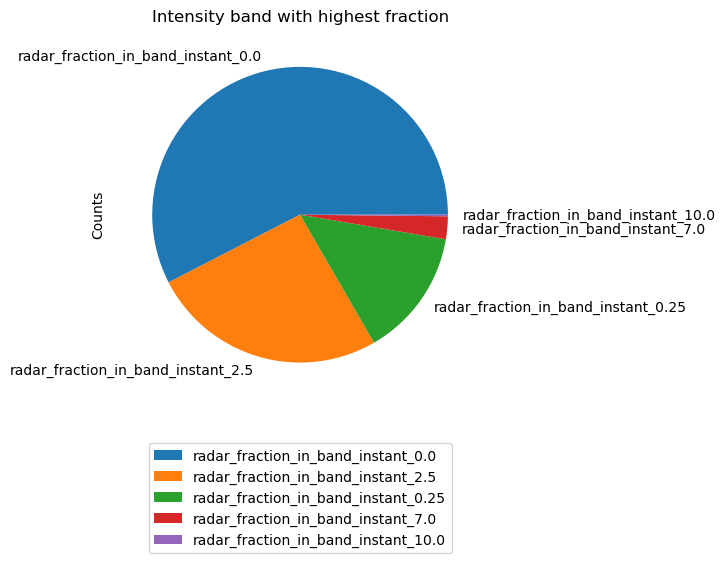

In [28]:
avg_df = pd.DataFrame({'Counts': tmp['max_bin'].value_counts()})
avg_df.plot.pie(subplots=True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1))
plt.title('Intensity band with highest fraction')
plt.show()

In [29]:
def pie_chart_mean_fractions_in_bands(df, title):
    """Calculates the average values of a pandas series provided and produces a pie chart"""
    avg_df = pd.DataFrame({'Average': df.mean()})
    avg_df.plot.pie(subplots=True)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1))
    plt.title(title)
    plt.show()

Produce pie chart for the average fraction in each intensity band for the train, test and validate datasets

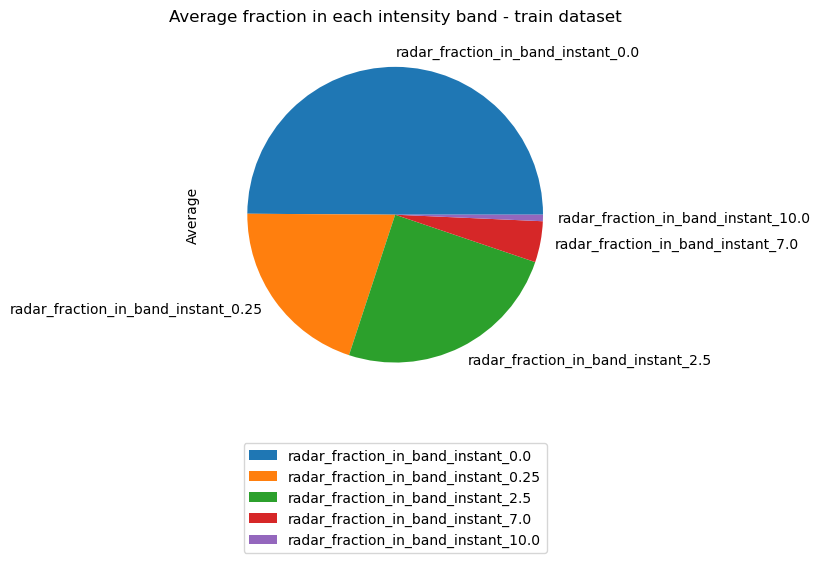

In [30]:
pie_chart_mean_fractions_in_bands(data_splits['y_train'], title='Average fraction in each intensity band - train dataset')

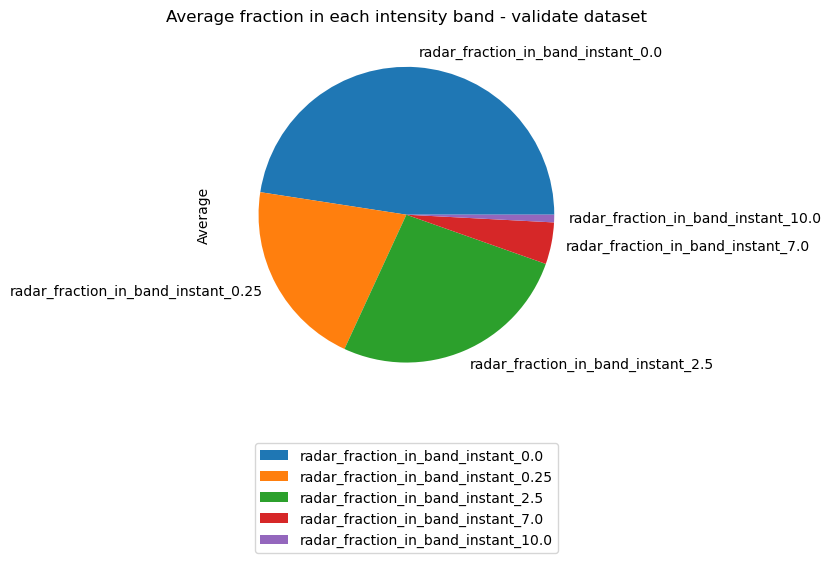

In [31]:
pie_chart_mean_fractions_in_bands(data_splits['y_val'], title='Average fraction in each intensity band - validate dataset')

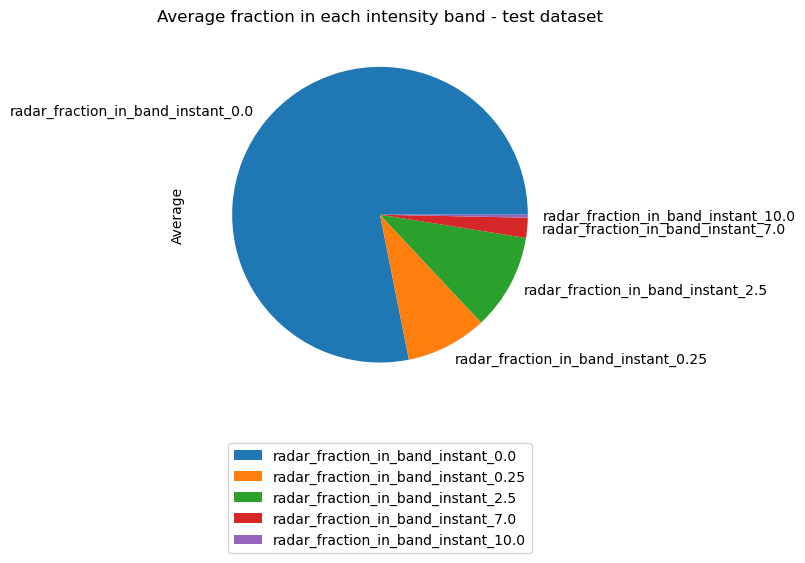

In [32]:
pie_chart_mean_fractions_in_bands(df_test[target_parameter], title='Average fraction in each intensity band - test dataset')

For each intensity band, select a subset which contains datapoint where the highest fraction falls into that intensity band, then produce the pie chart showing this average fraction in each intensity band. This allows us to see whether on average when a band has highest fraction whether it is marginally highest or is much higher than fractions of other bands.

/tmp/ipykernel_16740/1970291782.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  avg_df = pd.DataFrame({'Average': df.mean()})


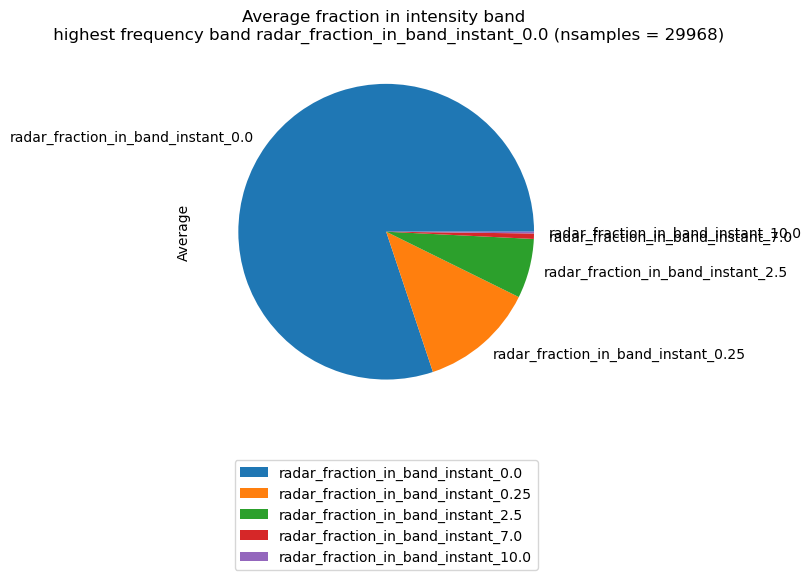

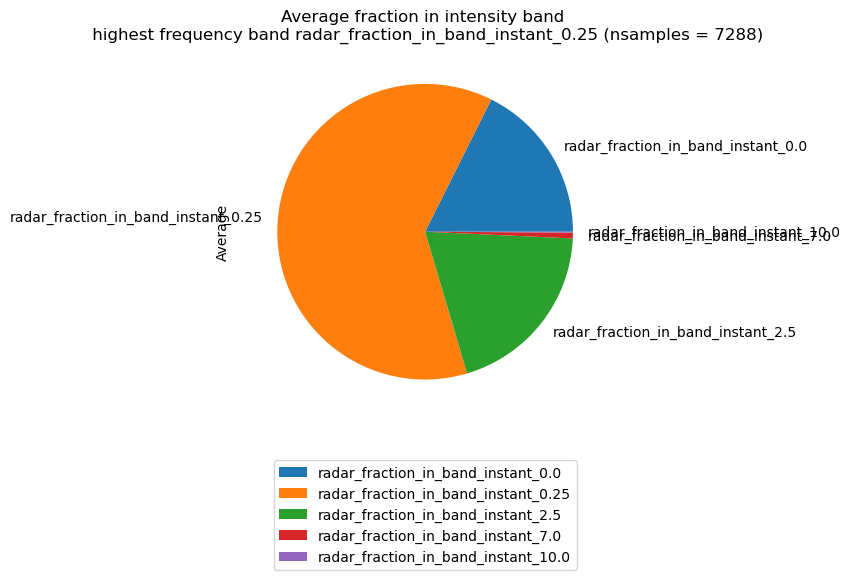

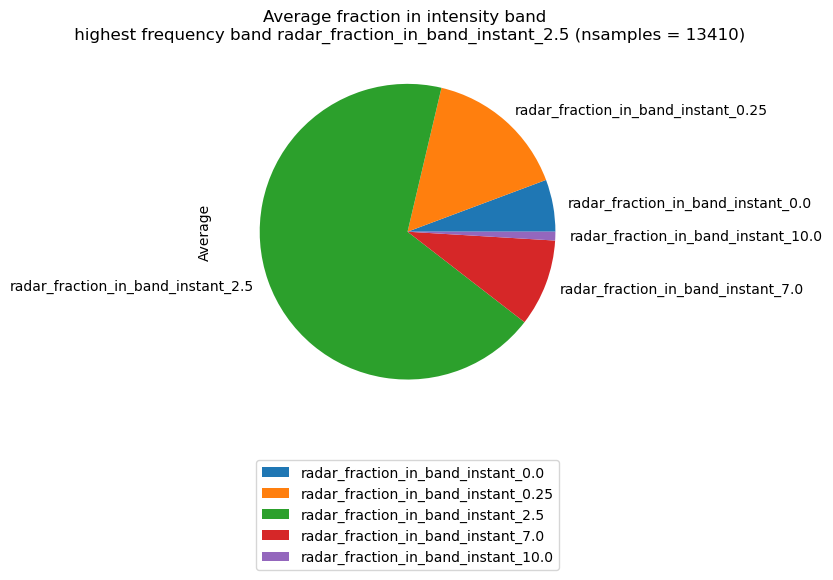

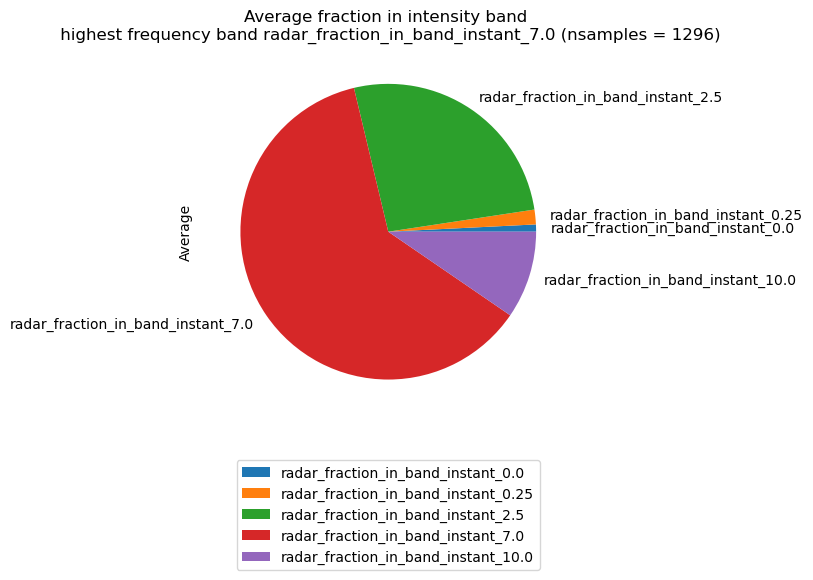

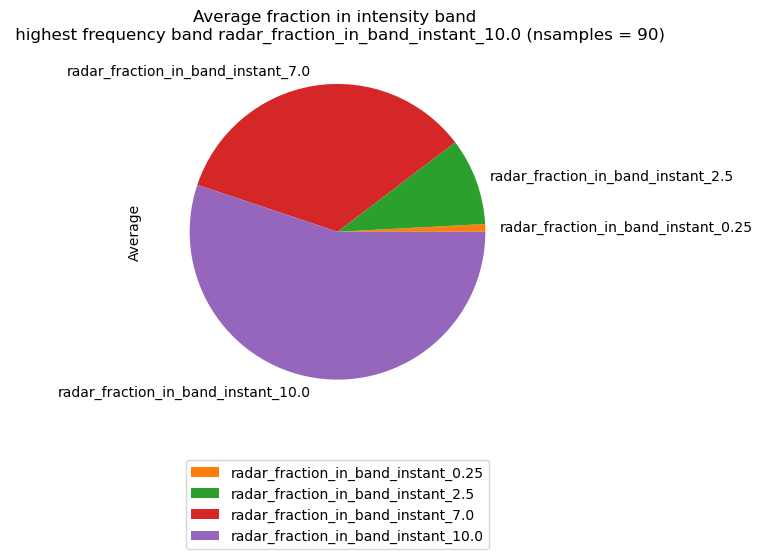

In [33]:
tmp = tmp.reset_index(drop=True)
for col in tmp.columns[0:-1]:
    subset = tmp[tmp['max_bin']==col]
    pie_chart_mean_fractions_in_bands(subset, title=f'Average fraction in intensity band \n highest frequency band {col} (nsamples = {len(subset)})')
    plt.show()

## Run experiment

Here we actually run the training and evaluation. All parameters and the output model will be saved through ML Flow, and we can track training stats through tensorboard.

In [34]:
exp_name='prd_fraction_models_mlflow'
exp1 = mlflow.create_experiment(exp_name)
exp1

'27014deb-848c-4241-966e-55b80a0c8ed4'

In [35]:
exp1 = mlflow.get_experiment(exp1)
exp1

<Experiment: artifact_location='', experiment_id='27014deb-848c-4241-966e-55b80a0c8ed4', lifecycle_stage='active', name='prd_fraction_models_mlflow', tags={}>

In [36]:
hyperparameter_dict = {
    'epochs': 10, 
    'learning_rate': 0.001, 
    'batch_size': 64
}

In [37]:
with mlflow.start_run(experiment_id=exp1.experiment_id) as current_run:
    mlflow.log_param('features', feature_dict['profile'] + feature_dict['single_level'])    
    model = prd_pipeline.build_model(**data_dims_dict)
    model.summary()
    model, history = prd_pipeline.train_model(model, data_splits, hyperparameter_dict)

2022-09-16 16:39:27.938837: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 profile_input (InputLayer)     [(None, 33, 4)]      0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 35, 4)       0           ['profile_input[0][0]']          
                                                                                                  
 conv1d (Conv1D)                (None, 33, 32)       384         ['zero_padding1d[0][0]']         
                                                                                                  
 zero_padding1d_1 (ZeroPadding1  (None, 35, 32)      0           ['conv1d[0][0]']                 
 D)                                                                                           

2022-09-16 16:40:28.163456: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmp899_kka2/model/data/model/assets


### Feature importance

Here we calculate the Breiman permutation importance for each of the model input features. This allows us to assess how much information each input feature is contributing to the resulting predictions from the ML model. 

 - At each step, only one predictor is permuted (randomized)
 - The amount by which the loss function increases when 𝑥 is randomized, is considered the importance of 𝑥
 - If the loss function increases slightly when 𝑥 is permuted, 𝑥 is somewhat important
 - If the loss function explodes when 𝑥 is permuted, 𝑥 is very important
 - If the loss function remains the same or decreases when 𝑥 is permuted, 𝑥 is not important

In [38]:
feature_names = feature_dict['profile'] + feature_dict['single_level']

In [39]:
# permute by shuffling data
permutation_importance = {key:[] for key in feature_names}
npermutations = 5

original_metric = history.history['val_loss'][-1]

for ifeature, feature in enumerate(feature_names):
    print(f'permuting feature: {feature}')
    for iperm in np.arange(npermutations):
        if data_dims_dict['nsinglvl_features'] > 0:
            X_val_permute = [data_splits['X_val'][0].copy(), data_splits['X_val'][1].copy()]
            if feature in feature_dict['single_level']:
                X_val_permute[1][feature] = X_val_permute[1][feature].reindex(
                    np.random.permutation(X_val_permute[1][feature].index)).values
            else:
                X_val_permute[0][..., ifeature] = np.take(
                    X_val_permute[0][..., ifeature],
                    indices=np.random.permutation(X_val_permute[0].shape[0]),
                    axis=0)
                
        else:
            X_val_permute = data_splits['X_val'].copy()
            X_val_permute[..., ifeature] = np.take(
                X_val_permute[..., ifeature],
                indices=np.random.permutation(X_val_permute.shape[0]),
                axis=0)

        y_pred = model.predict(X_val_permute)
        
        permuted_metric = tf.keras.metrics.KLDivergence()
        permuted_metric.update_state(data_splits['y_val'], y_pred)
        permuted_metric = permuted_metric.result().numpy()
        
        permutation_importance[feature].append(permuted_metric - original_metric)

permuting feature: air_temperature
permuting feature: relative_humidity
permuting feature: u_wind
permuting feature: v_wind


In [40]:
avg_importance = {}
for k,v in permutation_importance.items():
    avg_importance[k] = np.mean(v)
print(avg_importance)

{'air_temperature': 0.38027064204216005, 'relative_humidity': 0.35603700280189515, 'u_wind': 0.30232704281806944, 'v_wind': 0.33314633965492246}


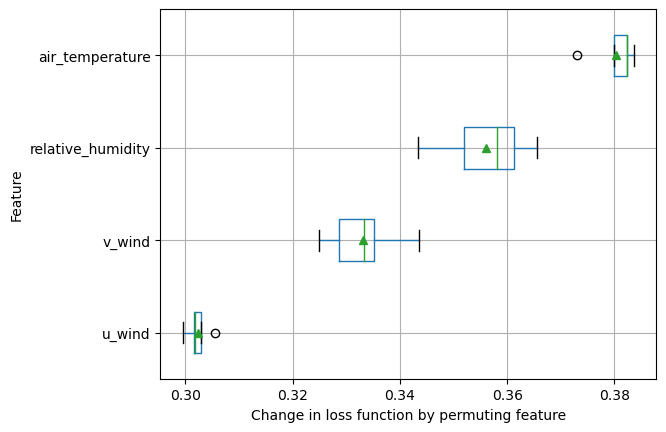

In [41]:
df = pd.DataFrame(permutation_importance)
df = df.reindex(columns=[k for k, v in sorted(avg_importance.items(), key=lambda item: item[1])])
df.boxplot(showmeans=True, vert=False)
plt.ylabel('Feature')
plt.xlabel('Change in loss function by permuting feature')
plt.show()

In [42]:
avg_importance = {}
for k,v in permutation_importance.items():
    avg_importance[k] = np.mean(v)
print(avg_importance)

{'air_temperature': 0.38027064204216005, 'relative_humidity': 0.35603700280189515, 'u_wind': 0.30232704281806944, 'v_wind': 0.33314633965492246}


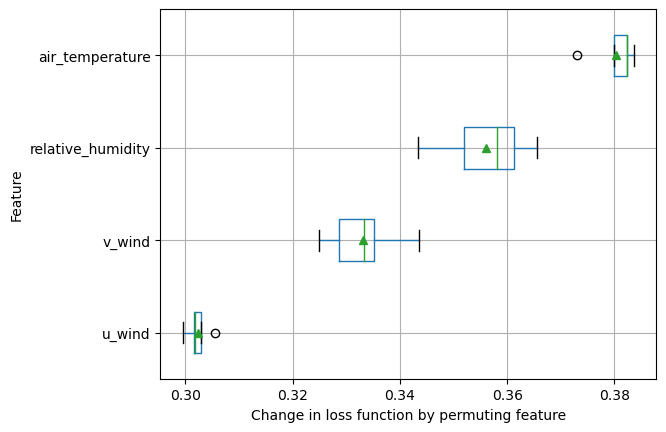

In [43]:
df = pd.DataFrame(permutation_importance)
df = df.reindex(columns=[k for k, v in sorted(avg_importance.items(), key=lambda item: item[1])])
df.boxplot(showmeans=True, vert=False)
plt.ylabel('Feature')
plt.xlabel('Change in loss function by permuting feature')
plt.show()

### Model evaluation

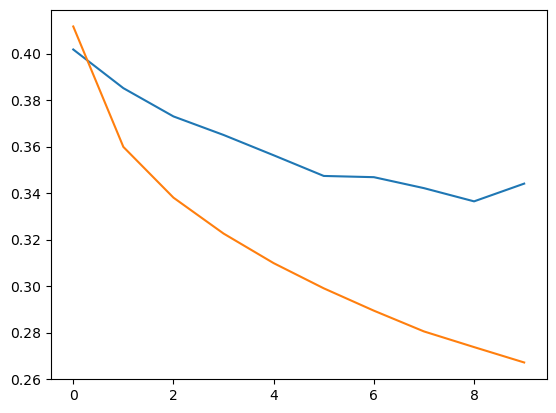

In [44]:
plt.plot(range(10),history.history['val_loss'])
plt.plot(range(10), history.history['loss'])

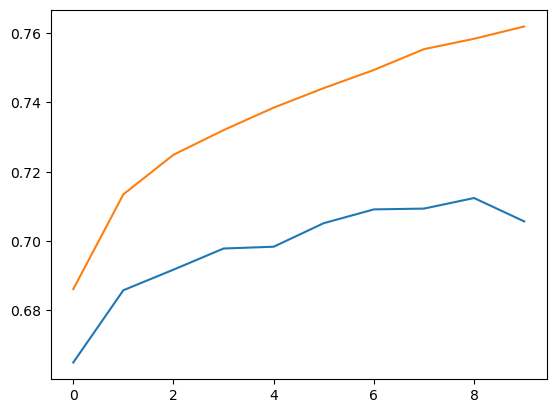

In [45]:
plt.plot(range(10), history.history['val_accuracy'])
plt.plot(range(10), history.history['accuracy'])

In [46]:
y_pred = model.predict(data_splits['X_val']) 

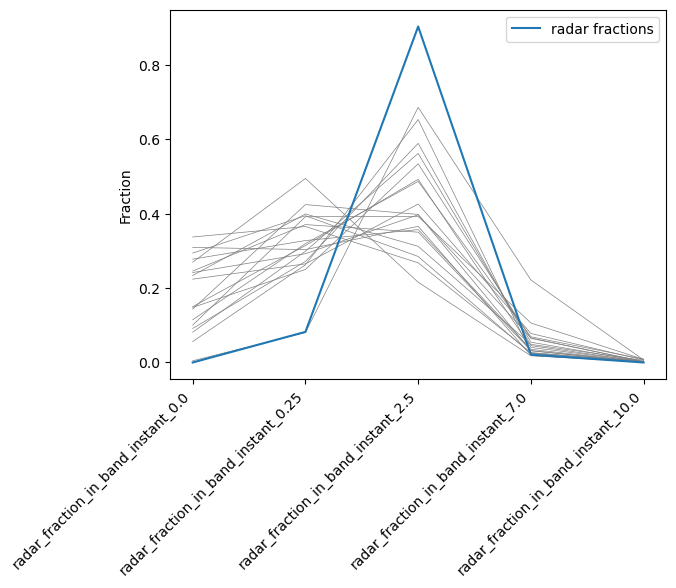

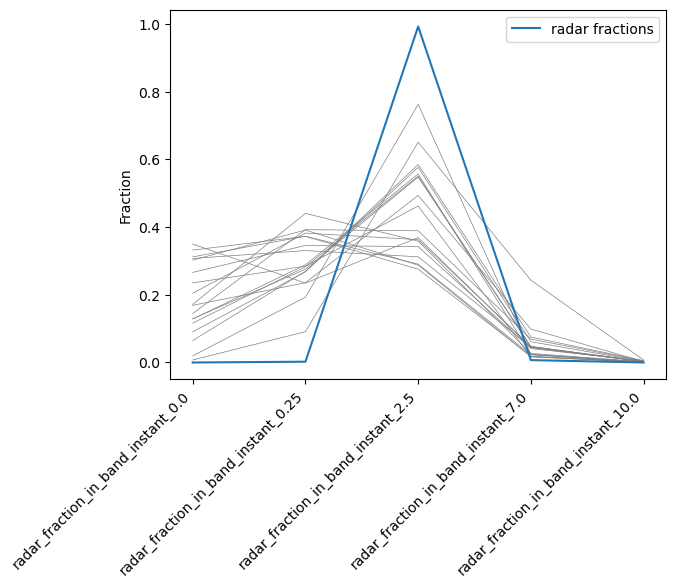

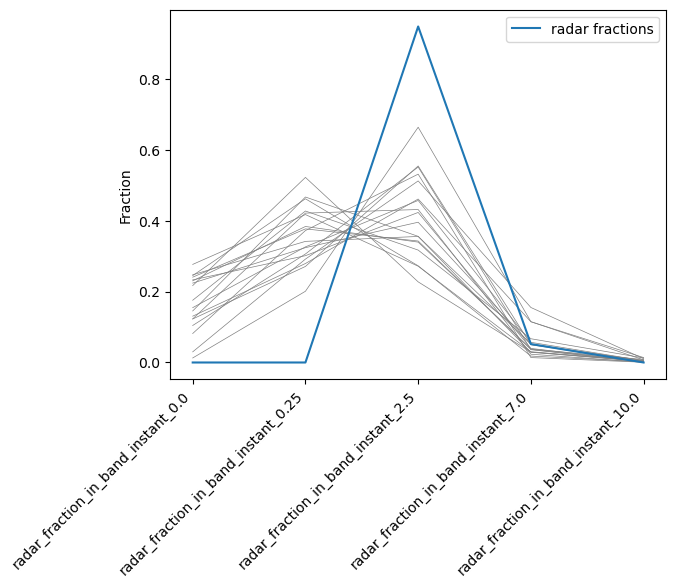

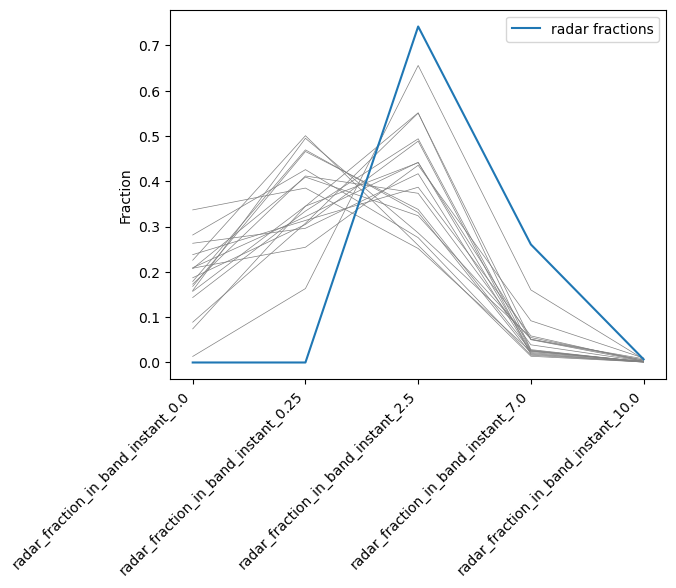

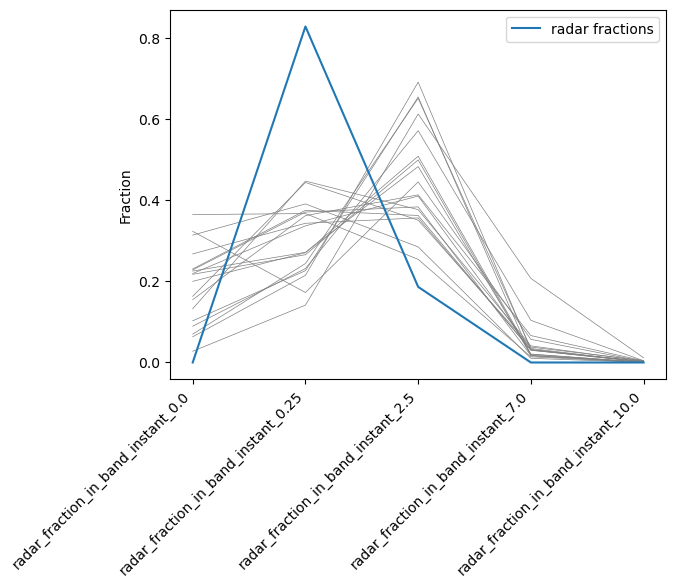

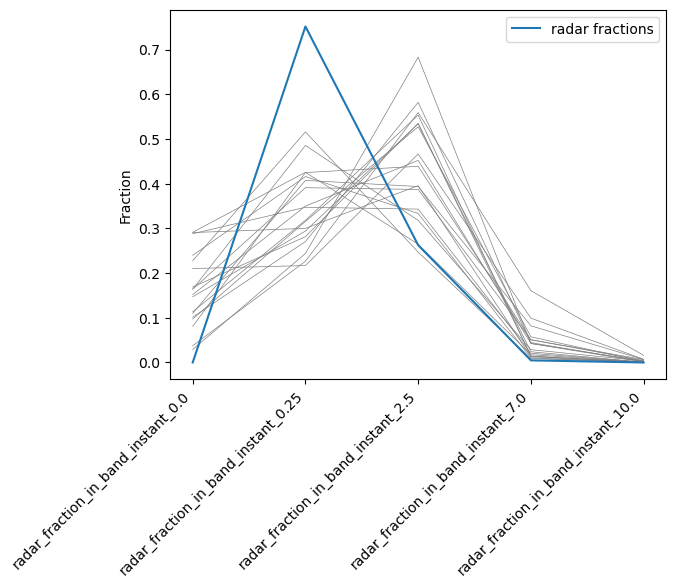

In [47]:
for loc in np.arange(0,91,18):
    for member in np.arange(18):
        plt.plot(y_pred[loc+member], lw=0.5, color='grey')
    plt.plot(data_splits['y_val'].iloc[loc+member], label='radar fractions')
    plt.ylabel('Fraction')
    plt.legend()
    plt.xticks(rotation=45, ha='right')
    plt.show()

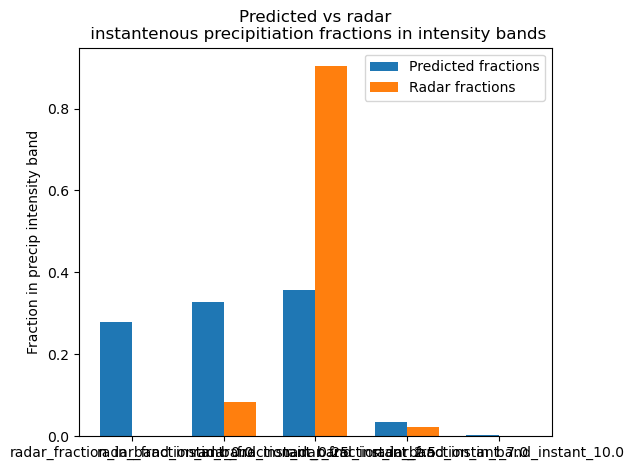

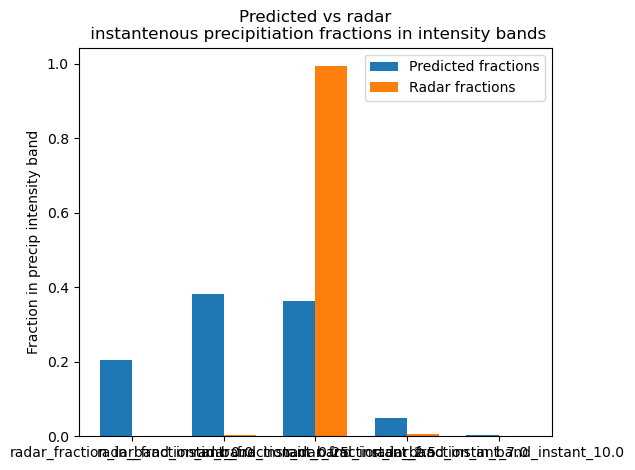

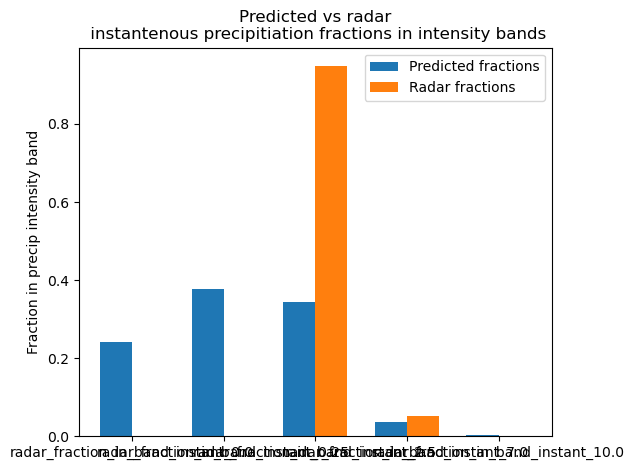

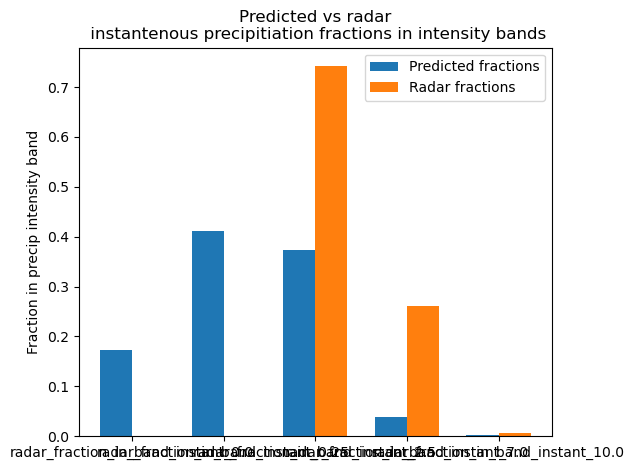

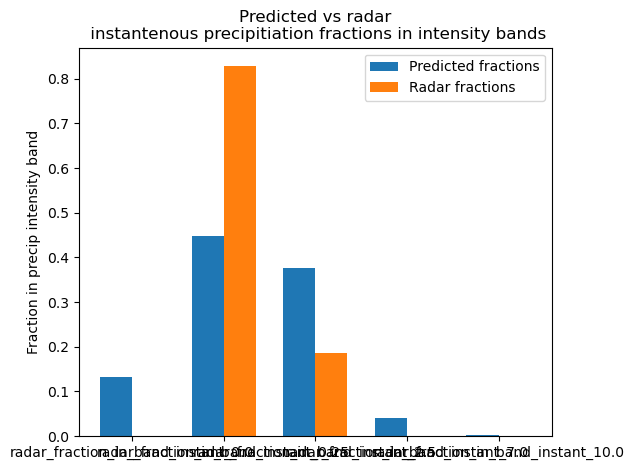

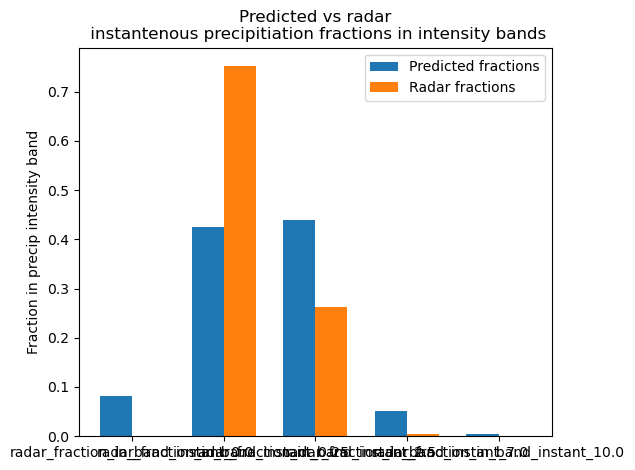

In [48]:
for loc in np.arange(0,91,18):
    x = np.arange(len(target_parameter))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, y_pred[loc], width, label='Predicted fractions')
    rects2 = ax.bar(x + width/2, data_splits['y_val'].iloc[loc], width, label='Radar fractions')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Fraction in precip intensity band')
    ax.set_title('Predicted vs radar\n instantenous precipitiation fractions in intensity bands')
    ax.set_xticks(x, target_parameter)
    ax.legend()

    fig.tight_layout()

    plt.show()
    # plt.bar(y_pred[loc], label='prediction')
    # plt.bar(data_splits['y_val'].iloc[loc], label='target')
    # plt.legend()
    # plt.show()

Fractional skill score

In [49]:
# non-cumulative i.e. assessing the FSS of specific bands individually
cols = data_splits['y_val'].columns
for i, col in enumerate(cols):
    FBS = (y_pred[:,i] - data_splits['y_val'][col])**2
    FBS_ref = y_pred[:,i]**2 + data_splits['y_val'][col]**2
    FSS = np.mean(1 - (FBS/FBS_ref))
    print(f'The FSS for predicting {col}mm/hh is {FSS}')

The FSS for predicting radar_fraction_in_band_instant_0.0mm/hh is 0.651081294640758
The FSS for predicting radar_fraction_in_band_instant_0.25mm/hh is 0.6393901033760934
The FSS for predicting radar_fraction_in_band_instant_2.5mm/hh is 0.5694442009039302
The FSS for predicting radar_fraction_in_band_instant_7.0mm/hh is 0.22766925394198806
The FSS for predicting radar_fraction_in_band_instant_10.0mm/hh is 0.0699907323167066


In [50]:
# cumulative
cols = data_splits['y_val'].columns
for i, col in enumerate(cols):
    FBS = (y_pred[:,:i+1].sum(axis=1) - data_splits['y_val'][cols[:i+1]].sum(axis=1))**2
    FBS_ref = y_pred[:,:i+1].sum(axis=1)**2 + data_splits['y_val'][cols[:i+1]].sum(axis=1)**2
    FSS = np.mean(1 - (FBS/FBS_ref))
    print(f'The FSS for predicting {col}mm/hh is {FSS}')

The FSS for predicting radar_fraction_in_band_instant_0.0mm/hh is 0.651081294640758
The FSS for predicting radar_fraction_in_band_instant_0.25mm/hh is 0.822675359892879
The FSS for predicting radar_fraction_in_band_instant_2.5mm/hh is 0.9850354708674937
The FSS for predicting radar_fraction_in_band_instant_7.0mm/hh is 0.9987435650756933
The FSS for predicting radar_fraction_in_band_instant_10.0mm/hh is 0.9999089675588799


In [51]:
cols

Index(['radar_fraction_in_band_instant_0.0',
       'radar_fraction_in_band_instant_0.25',
       'radar_fraction_in_band_instant_2.5',
       'radar_fraction_in_band_instant_7.0',
       'radar_fraction_in_band_instant_10.0'],
      dtype='object')